# Tutorial 3A
Welcome to this lab session, where we will dive into the intriguing world of attacks and defenses in federated learning. This session is part of a series that includes Tutorials 3A, 3B, and Homework 3.

## Init Environment
To kick things off, let's first initialize the federated learning environment, building upon the foundational code introduced in Tutorial 1A.



In [1]:
from base import *
# change the device by changing the base code
'''
if torch.cuda.is_available():
    gpu_type = torch.cuda.get_device_name(0)
    print("GPU Type:", gpu_type)
'''
sample_split = split(100, True, 42)
fedavg_server = FedAvgServer(0.02, 200, sample_split, 0.2, 2, 42)
result_fedavg = fedavg_server.run(10)
fedavg_df = result_fedavg.as_df()
fedavg_df

,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,FedAvg,100,0.2,200,2,0.02,42,40,23.28
1,2,FedAvg,100,0.2,200,2,0.02,42,80,54.96
2,3,FedAvg,100,0.2,200,2,0.02,42,120,68.12
3,4,FedAvg,100,0.2,200,2,0.02,42,160,75.03
4,5,FedAvg,100,0.2,200,2,0.02,42,200,76.76
5,6,FedAvg,100,0.2,200,2,0.02,42,240,81.25
6,7,FedAvg,100,0.2,200,2,0.02,42,280,82.64
7,8,FedAvg,100,0.2,200,2,0.02,42,320,84.49
8,9,FedAvg,100,0.2,200,2,0.02,42,360,85.83
9,10,FedAvg,100,0.2,200,2,0.02,42,400,87.29


We will introduce a slight modification to the WeightClient and FedAvgServer components. Previously, clients were designed to upload their local model to the server. In this updated approach, we shift the focus towards uploading the gradient instead. This gradient represents the difference between the updated local model and the prior local model following local training sessions.

|               | Previous Approach (Model Upload)                                     | Updated Approach (Gradient Upload)                                          |
|-------------------------------|----------------------------------------------------------------------|----------------------------------------------------------------------------|
| **Equation for Update**       | $$M_{\text{global}}^{t+1} = \frac{1}{N} \sum_{i=1}^{N} M_{i}^{(t+1)}$$ | $$ M_{\text{global}}^{(t+1)} = M_{\text{global}}^{(t)} -  \frac{1}{N} \sum_{i=1}^{N} g_{i}^{(t)} $$where $$
g_i^{(t)}=M_{i}^{(t)}-M_{i}^{(t+1)}
$$


In [2]:
class GradWeightClient(Client):
    def __init__(self, client_data: Subset, lr: float, batch_size: int, nr_epochs: int) -> None:
        super().__init__(client_data, batch_size)
        self.optimizer = SGD(params=self.model.parameters(), lr=lr)
        self.nr_epochs = nr_epochs

    def update(self, weights: list[torch.Tensor], seed: int) -> list[torch.Tensor]:
        # Load the server weights into the model
        with torch.no_grad():
            for client_values, server_values in zip(self.model.parameters(), weights):
                client_values[:] = server_values

        self.generator.manual_seed(seed)

        # Save initial weights to calculate the gradients later
        initial_weights = [param.clone() for param in self.model.parameters()]

        for _epoch in range(self.nr_epochs):
            train_epoch(self.model, self.loader_train, self.optimizer)

        # Calculate gradients: initial_weights - final_weights
        gradients = [initial_weight - final_weight for final_weight, initial_weight in zip(self.model.parameters(), initial_weights)]
        return [gradient.detach().cpu().clone() for gradient in gradients]

class FedAvgGradServer(DecentralizedServer):
    def __init__(
            self, lr: float, batch_size: int, client_subsets: list[Subset],
            client_fraction: float, nr_local_epochs: int, seed: int) -> None:
        super().__init__(lr, batch_size, client_subsets, client_fraction, seed)
        self.name = "FedAvg"
        self.nr_local_epochs = nr_local_epochs
        self.clients = [
            GradWeightClient(subset, lr, batch_size, nr_local_epochs)
            for subset in client_subsets]

    def run(self, nr_rounds: int) -> RunResult:
        elapsed_time = 0.
        run_result = RunResult(self.name, self.nr_clients, self.client_fraction, self.batch_size, self.nr_local_epochs, self.lr, self.seed)

        # Initial server weights
        server_weights = [param.data.clone() for param in self.model.parameters()]

        for nr_round in tqdm(range(nr_rounds), desc="Rounds", leave=False):
            # Other code remains the same until the aggregation part
            setup_start_time = perf_counter()
            self.model.train()
            weights = [x.detach().cpu().clone() for x in self.model.parameters()]
            indices_chosen_clients = self.rng.choice(self.nr_clients, self.nr_clients_per_round, replace=False)
            chosen_sum_nr_samples = sum(self.client_sample_counts[i] for i in indices_chosen_clients)
            chosen_adjusted_weights: list[list[torch.Tensor]] = []
            elapsed_time += perf_counter() - setup_start_time
            update_time = 0.

            for c_i in indices_chosen_clients:
                update_start_time = perf_counter()
                ind = int(c_i)
                client_round_seed = self.seed + ind + 1 + nr_round * self.nr_clients_per_round
                client_weights = self.clients[ind].update(weights, client_round_seed)
                chosen_adjusted_weights.append([
                    self.client_sample_counts[ind] / chosen_sum_nr_samples * tens
                     for tens in client_weights])
                update_time = max(update_time, perf_counter() - update_start_time)

            elapsed_time += update_time
            aggregate_start_time = perf_counter()
            averaged_gradients: list[torch.Tensor] = [sum(x) for x in zip(*chosen_adjusted_weights)]

            # Update server model with averaged gradients
            with torch.no_grad():
                for server_weight, gradient in zip(server_weights, averaged_gradients):
                    server_weight -= gradient.to(device=device)  # Assume learning rate is absorbed in gradient

            # Distribute updated weights to clients
            with torch.no_grad():
                for param, server_weight in zip(self.model.parameters(), server_weights):
                    param.data[:] = server_weight.data


            elapsed_time += perf_counter() - aggregate_start_time
            run_result.wall_time.append(round(elapsed_time, 1))
            run_result.message_count.append(2 * (nr_round + 1) * self.nr_clients_per_round)
            run_result.test_accuracy.append(self.test())

        return run_result


Upon examination, it becomes evident that the two methods are, in essence, identical.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fedavg_server = FedAvgGradServer(0.02, 200, sample_split, 0.2, 2, 42)
result_fedavg = fedavg_server.run(10)
fedavg_df = result_fedavg.as_df()
fedavg_df

,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,FedAvg,100,0.2,200,2,0.02,42,40,23.28
1,2,FedAvg,100,0.2,200,2,0.02,42,80,54.95
2,3,FedAvg,100,0.2,200,2,0.02,42,120,68.09
3,4,FedAvg,100,0.2,200,2,0.02,42,160,75.04
4,5,FedAvg,100,0.2,200,2,0.02,42,200,76.80
5,6,FedAvg,100,0.2,200,2,0.02,42,240,81.25
6,7,FedAvg,100,0.2,200,2,0.02,42,280,82.63
7,8,FedAvg,100,0.2,200,2,0.02,42,320,84.49
8,9,FedAvg,100,0.2,200,2,0.02,42,360,85.85
9,10,FedAvg,100,0.2,200,2,0.02,42,400,87.31


## Poisoning Attacks
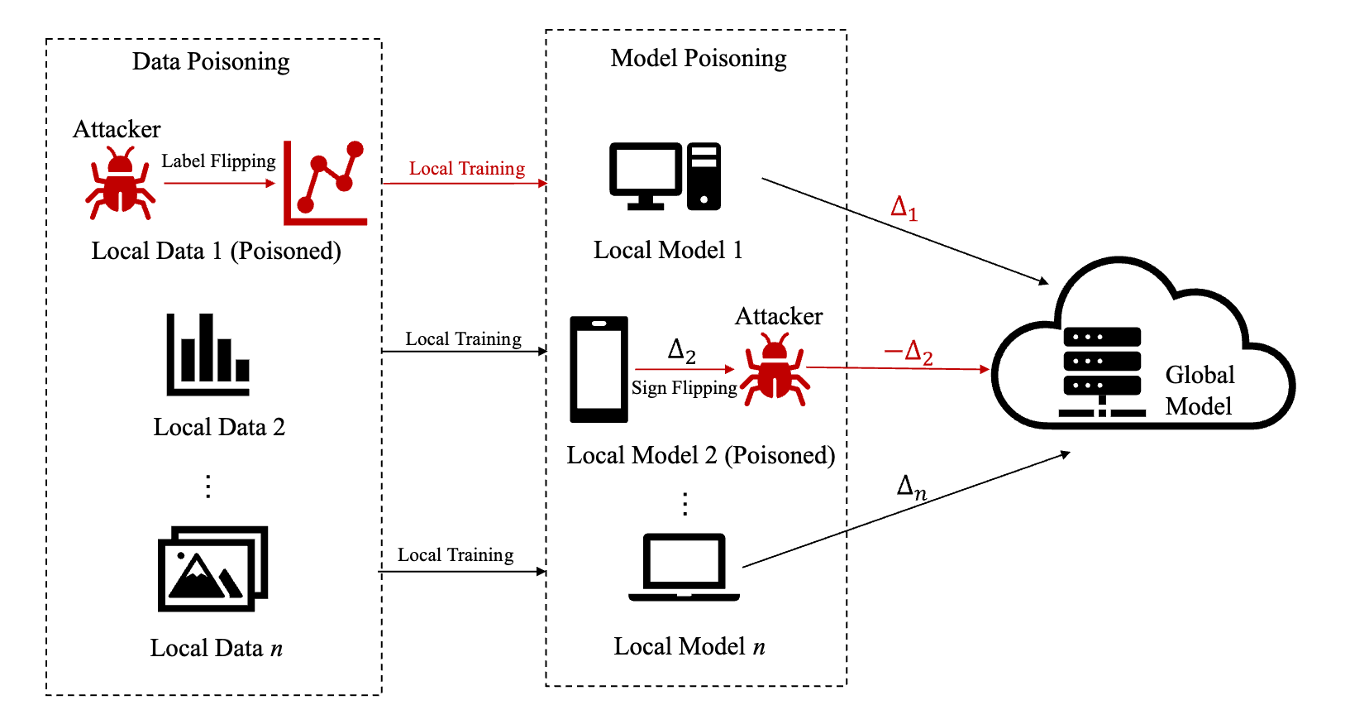

## Model Poisoning Attacks

In federated learning, a model poisoning attack can significantly compromise the model's integrity. In these attacks, malicious clients directly change their model updates. This tutorial demonstrates a basic form of such an attack: the Gradient Reversion Attack. Malicious clients invert their gradient updates, essentially "misleading" the server during the model's training process.
$$g_i^{(t)}=-kg_i^{(t)}$$

In [4]:
# malicious clients
class AttackerGradientReversion(GradWeightClient):
    def update(self, weights: list[torch.Tensor], seed: int) -> list[torch.Tensor]:
        # Call the base implementation to perform the normal training and update process
        honest_gradients = super().update(weights, seed)

        # Reverse the gradients: for a malicious client, negate the weights to simulate an attack
        reversed_gradients = [-5*w for w in honest_gradients]

        return reversed_gradients

fedavg_server_reverse = FedAvgGradServer(0.02, 200, sample_split, 0.2, 2, 42)
clients = fedavg_server_reverse.clients
# Number of clients to be made malicious with gradient reversion
num_malicious = int(0.20 * len(clients))  # For example, 20%
# Randomly select indices for the clients to undergo gradient inversion attack
malicious_indices = np.random.choice(len(clients), num_malicious, replace=False)

# Replace the selected clients with instances of AttackerGradientInversion
for idx in malicious_indices:
    client_data = clients[idx].loader_train.dataset
    lr = clients[idx].optimizer.param_groups[0]['lr']
    batch_size = clients[idx].loader_train.batch_size
    nr_epochs = clients[idx].nr_epochs
    clients[idx] = AttackerGradientReversion(client_data, lr, batch_size, nr_epochs)

result_fedavg_reverse = fedavg_server_reverse.run(10)
fedavg_df_reverse = result_fedavg_reverse.as_df()
fedavg_df_reverse

,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,FedAvg,100,0.2,200,2,0.02,42,40,7.69
1,2,FedAvg,100,0.2,200,2,0.02,42,80,10.46
2,3,FedAvg,100,0.2,200,2,0.02,42,120,9.82
3,4,FedAvg,100,0.2,200,2,0.02,42,160,14.02
4,5,FedAvg,100,0.2,200,2,0.02,42,200,11.56
5,6,FedAvg,100,0.2,200,2,0.02,42,240,10.05
6,7,FedAvg,100,0.2,200,2,0.02,42,280,12.25
7,8,FedAvg,100,0.2,200,2,0.02,42,320,17.44
8,9,FedAvg,100,0.2,200,2,0.02,42,360,22.15
9,10,FedAvg,100,0.2,200,2,0.02,42,400,25.09


## Data Poisoning Attacks
Next, we explore data poisoning attacks, where malicious clients tamper with their datasets to further compromise the model. Unlike model poisoning attacks that manipulate model updates, data poisoning involves corrupting the data itself. There are several types of data poisoning attacks, and here we focus on an untargeted data poisoning attack.

In this approach, attackers intentionally corrupt their data by mislabeling it. They flip the labels to incorrect values, aiming to degrade the model's ability to learn accurate patterns. This method doesn't target specific model outcomes; instead, it broadly seeks to reduce overall model performance and reliability.

In [5]:
class AttackerUntargetedFlipping(WeightClient):
    def train_epoch(self, model: torch.nn.Module, loader: DataLoader, optimizer: Optimizer) -> None:
        model.train()
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            # Flip the target to another random label
            target = self.flip_labels(target)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

    def flip_labels(self, labels):
        num_classes = 10
        # Generate random shifts for each label, ensuring no shift is zero to guarantee label change
        # shifts = torch.randint(low=1, high=num_classes, size=labels.shape, device=labels.device)
        shifts = 1
        # Apply shifts and take modulus to ensure new labels are within valid range
        new_labels = (labels + shifts) % num_classes
        return new_labels


    def update(self, weights: list[torch.Tensor], seed: int) -> list[torch.Tensor]:
        # Load the server weights into the model
        with torch.no_grad():
            for client_values, server_values in zip(self.model.parameters(), weights):
                client_values[:] = server_values

        self.generator.manual_seed(seed)

        # Save initial weights to calculate the gradients later
        initial_weights = [param.clone() for param in self.model.parameters()]

        for _epoch in range(self.nr_epochs):
            self.train_epoch(self.model, self.loader_train, self.optimizer)

        # Calculate gradients: final_weights - initial_weights
        gradients = [5*(initial_weight - final_weight) for final_weight, initial_weight in zip(self.model.parameters(), initial_weights)]

        return [gradient.detach().cpu().clone() for gradient in gradients]

In [6]:
fedavg_server_ut_flip = FedAvgGradServer(0.02, 200, sample_split, 0.2, 2, 42)
clients = fedavg_server_ut_flip.clients
# Number of clients to be made malicious with gradient inversion
num_malicious = int(0.2 * len(clients))  # For example, 20%
# Randomly select indices for the clients to undergo gradient inversion attack
malicious_indices = np.random.choice(len(clients), num_malicious, replace=False)

# Replace the selected clients with instances of AttackerUntargetedFlipping
for idx in malicious_indices:
    client_data = clients[idx].loader_train.dataset
    lr = clients[idx].optimizer.param_groups[0]['lr']
    batch_size = clients[idx].loader_train.batch_size
    nr_epochs = clients[idx].nr_epochs
    clients[idx] = AttackerUntargetedFlipping(client_data, lr, batch_size, nr_epochs)

result_fedavg_ut_flip = fedavg_server_ut_flip.run(10)
fedavg_df_ut_flip = result_fedavg_ut_flip.as_df()
fedavg_df_ut_flip

,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,FedAvg,100,0.2,200,2,0.02,42,40,27.29
1,2,FedAvg,100,0.2,200,2,0.02,42,80,20.33
2,3,FedAvg,100,0.2,200,2,0.02,42,120,16.81
3,4,FedAvg,100,0.2,200,2,0.02,42,160,21.87
4,5,FedAvg,100,0.2,200,2,0.02,42,200,32.71
5,6,FedAvg,100,0.2,200,2,0.02,42,240,56.76
6,7,FedAvg,100,0.2,200,2,0.02,42,280,25.94
7,8,FedAvg,100,0.2,200,2,0.02,42,320,56.34
8,9,FedAvg,100,0.2,200,2,0.02,42,360,68.43
9,10,FedAvg,100,0.2,200,2,0.02,42,400,15.16


We now turn to targeted data poisoning, where malicious clients intentionally mislabel data to influence the model in specific ways. This approach is more calculated than broad-scale disruption, aiming to skew the model's predictions on particular inputs.

In [7]:
class AttackerTargetedFlipping(GradWeightClient):
    def train_epoch(self, model: torch.nn.Module, loader: DataLoader, optimizer: Optimizer) -> None:
        model.train()
        for data, target in loader:
            # Flip the target to another random label
            data, target = data.to(device), target.to(device)
            target = self.flip_labels(target)

            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

    def flip_labels(self, labels):
        # Targeted flip: Change all 0s to 6s
        new_labels = labels.clone()  # Make a copy to avoid changing the original labels
        new_labels[labels == 0] = 6  # Change all labels from 0 to 6
        return new_labels


    def update(self, weights: list[torch.Tensor], seed: int) -> list[torch.Tensor]:
        # Load the server weights into the model
        with torch.no_grad():
            for client_values, server_values in zip(self.model.parameters(), weights):
                client_values[:] = server_values

        self.generator.manual_seed(seed)

        # Save initial weights to calculate the gradients later
        initial_weights = [param.clone() for param in self.model.parameters()]

        for _epoch in range(self.nr_epochs):
            self.train_epoch(self.model, self.loader_train, self.optimizer)

        # Calculate gradients: final_weights - initial_weights
        gradients = [5*(initial_weight - final_weight) for final_weight, initial_weight in zip(self.model.parameters(), initial_weights)]

        return [gradient.detach().cpu().clone() for gradient in gradients]

In [8]:
fedavg_server_t_flip = FedAvgGradServer(0.02, 200, sample_split, 0.2, 2, 42)
clients = fedavg_server_t_flip.clients
# Number of clients to be made malicious with gradient inversion
num_malicious = int(0.2 * len(clients))  # For example, 20%
# Randomly select indices for the clients to undergo gradient inversion attack
malicious_indices = np.random.choice(len(clients), num_malicious, replace=False)

# Replace the selected clients with instances of AttackerTargetedFlipping
for idx in malicious_indices:
    client_data = clients[idx].loader_train.dataset
    lr = clients[idx].optimizer.param_groups[0]['lr']
    batch_size = clients[idx].loader_train.batch_size
    nr_epochs = clients[idx].nr_epochs
    clients[idx] = AttackerTargetedFlipping(client_data, lr, batch_size, nr_epochs)

result_fedavg_t_flip = fedavg_server_t_flip.run(10)
fedavg_df_t_flip = result_fedavg_t_flip.as_df()
fedavg_df_t_flip

,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,FedAvg,100,0.2,200,2,0.02,42,40,9.65
1,2,FedAvg,100,0.2,200,2,0.02,42,80,31.58
2,3,FedAvg,100,0.2,200,2,0.02,42,120,65.31
3,4,FedAvg,100,0.2,200,2,0.02,42,160,70.36
4,5,FedAvg,100,0.2,200,2,0.02,42,200,68.89
5,6,FedAvg,100,0.2,200,2,0.02,42,240,68.54
6,7,FedAvg,100,0.2,200,2,0.02,42,280,75.89
7,8,FedAvg,100,0.2,200,2,0.02,42,320,81.71
8,9,FedAvg,100,0.2,200,2,0.02,42,360,81.89
9,10,FedAvg,100,0.2,200,2,0.02,42,400,81.25


From the results, the global test accuracy remains largely unaffected in this scenario. Next, we'll use a confusion matrix to examine the detailed impact on predictions across all classes.
> A confusion matrix, as the name suggests, is a matrix of numbers that tell us where a model gets confused. It is a class-wise distribution of the predictive performance of a classification model—that is, the confusion matrix is an organized way of mapping the predictions to the original classes to which the data belong.

In [9]:
# confusion matrix generation
def confusion_matrix(model, test_loader: DataLoader, num_classes: int) -> (float, np.ndarray):
    correct = 0
    model.eval()
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.int64)

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            # Update confusion matrix
            for t, p in zip(target.view(-1), pred.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    accuracy = 100. * correct / len(test_loader.dataset)
    return accuracy, confusion_matrix

acc, confusion_matrix = confusion_matrix(fedavg_server.model, test_loader, 10)

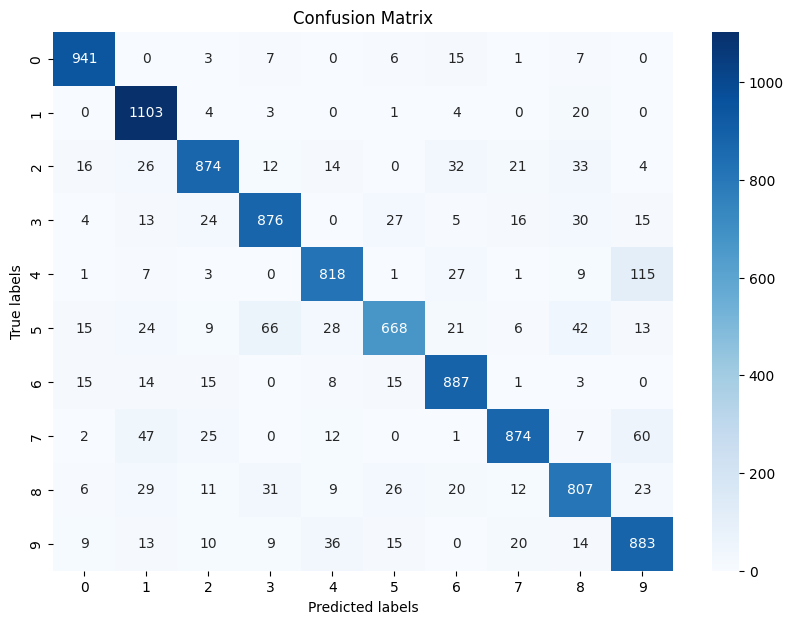

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
plot_confusion_matrix(confusion_matrix, class_names=[str(i) for i in range(10)])

In [11]:
# confusion matrix generation
def confusion_matrix(model, test_loader: DataLoader, num_classes: int) -> (float, np.ndarray):
    correct = 0
    model.eval()
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.int64)

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            # Update confusion matrix
            for t, p in zip(target.view(-1), pred.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    accuracy = 100. * correct / len(test_loader.dataset)
    return accuracy, confusion_matrix

acc, confusion_matrix = confusion_matrix(fedavg_server_t_flip.model, test_loader, 10)

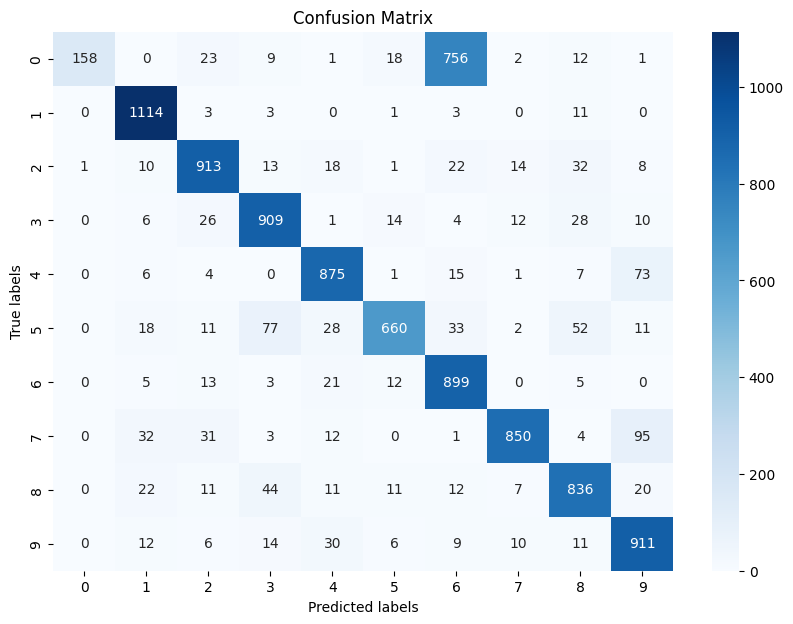

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
plot_confusion_matrix(confusion_matrix, class_names=[str(i) for i in range(10)])

## Backdoor Attacks
Backdoor attacks represent a sophisticated and stealthy subset of data poisoning techniques in machine learning, particularly concerning in federated learning scenarios. Unlike conventional poisoning strategies that aim to degrade overall model performance, backdoor attacks are designed with subtlety and specificity in mind. They introduce a malicious function into the model that is activated only under certain conditions—specifically, when a particular pattern, or "trigger," is present in the input data.
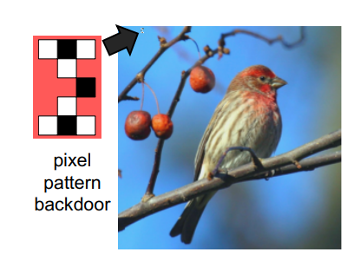

Let's begin by developing code for a synthesizer that will introduce triggers into our data.

In [13]:
import random

# a new data class that help us to process batch
@dataclass
class Batch:
    batch_id: int
    inputs: torch.Tensor
    labels: torch.Tensor

    def __post_init__(self):
        self.batch_size = self.inputs.shape[0]

    def to(self, device):
        inputs = self.inputs.to(device)
        labels = self.labels.to(device)
        return Batch(self.batch_id, inputs, labels)

    def clone(self):
        inputs = self.inputs.clone()
        labels = self.labels.clone()
        return Batch(self.batch_id, inputs, labels)


    def clip(self, batch_size):
        if batch_size is None:
            return self

        inputs = self.inputs[:batch_size]
        labels = self.labels[:batch_size]

        return Batch(self.batch_id, inputs, labels)

class Synthesizer:
    def __init__(self, poisoning_proportion):
        self.poisoning_proportion = poisoning_proportion

    def make_backdoor_batch(self, batch: Batch, test=False, attack=True) -> Batch:
        if not attack:
            return batch

        if test:
            attack_portion = batch.batch_size
        else:
            attack_portion = round(
                batch.batch_size * self.poisoning_proportion)

        backdoored_batch = batch.clone()
        self.apply_backdoor(backdoored_batch, attack_portion)
        return backdoored_batch

    def apply_backdoor(self, batch, attack_portion):
        """
        Modifies only a portion of the batch (represents batch poisoning).

        :param batch:
        :return:
        """
        self.synthesize_inputs(batch=batch, attack_portion=attack_portion)
        self.synthesize_labels(batch=batch, attack_portion=attack_portion)

        return

    def synthesize_inputs(self, batch, attack_portion=None):
        raise NotImplemented

    def synthesize_labels(self, batch, attack_portion=None):
        raise NotImplemented

class PatternSynthesizer(Synthesizer):
    pattern_tensor: torch.Tensor = torch.tensor([
        [1., 0., 1.],
        [-10., 1., -10.],
        [-10., -10., 0.],
        [-10., 1., -10.],
        [1., 0., 1.]
    ])
    "Just some random 2D pattern."

    x_top = 3
    "X coordinate to put the backdoor into."
    y_top = 23
    "Y coordinate to put the backdoor into."

    mask_value = -10
    "A tensor coordinate with this value won't be applied to the image."

    resize_scale = (5, 10)
    "If the pattern is dynamically placed, resize the pattern."

    mask: torch.Tensor = None
    "A mask used to combine backdoor pattern with the original image."

    pattern: torch.Tensor = None
    "A tensor of the `input.shape` filled with `mask_value` except backdoor."

    def __init__(self, poisoning_proportion):
        super().__init__(poisoning_proportion)
        self.input_shape = (1, 28, 28)
        self.backdoor_label = 0
        self.normalize = transforms.Normalize((0.1307,), (0.3081,))
        self.make_pattern(self.pattern_tensor, self.x_top, self.y_top)


    def make_pattern(self, pattern_tensor, x_top, y_top):
        # put pattern into the image
        full_image = torch.zeros(self.input_shape)
        full_image.fill_(self.mask_value)
        # full image has a pixel value of -10
        x_bot = x_top + pattern_tensor.shape[0]
        y_bot = y_top + pattern_tensor.shape[1]

        if x_bot >= self.input_shape[1] or \
                y_bot >= self.input_shape[2]:
            raise ValueError(f'Position of backdoor outside image limits:'
                             f'image: {self.input_shape}, but backdoor'
                             f'ends at ({x_bot}, {y_bot})')

        full_image[:, x_top:x_bot, y_top:y_bot] = pattern_tensor
        # full image has a pixel value of -10 except for the backdoor (pattern_tensor) size: 5 * 3
        self.mask = 1 * (full_image != self.mask_value).to(device) # (0, 1)
        # mask is a tensor of 0 and 1, 0 for -10 and 1 for other values
        self.pattern = self.normalize(full_image).to(device) # )(-52.5678, 2.7537)


    def synthesize_inputs(self, batch, attack_portion=None):
        pattern, mask = self.get_pattern()
        # mask value (0, 1); value 0, keep the original image; value 1, replace with pattern
        batch.inputs[:attack_portion] = (1 - mask) * \
                                        batch.inputs[:attack_portion] + \
                                        mask * pattern

        return

    def synthesize_labels(self, batch, attack_portion=None):
        batch.labels[:attack_portion].fill_(self.backdoor_label)
        return

    def get_pattern(self):
        return self.pattern, self.mask

In [14]:
test_syn_loader = DataLoader(
    datasets.MNIST(data_path_str, train=False, download=False, transform=transform),
    shuffle=False, drop_last=False, batch_size=8, generator=torch.Generator())

# Instantiate the synthesizer with a poisoning proportion
poisoning_proportion = 0.5
synthesizer = PatternSynthesizer(poisoning_proportion=poisoning_proportion)

# Fetch a test batch
for batch_idx, (inputs, labels) in enumerate(test_syn_loader):
    test_batch = Batch(batch_idx, inputs, labels)
    test_batch = test_batch.to(device)
    break  # Only take the first batch for testing

# Apply backdoor
backdoored_batch = synthesizer.make_backdoor_batch(test_batch, test=False, attack=True)

In the code snippet provided, invoking the synthesizer.make_backdoor_batch function results in half of the data within a batch being compromised with backdoor triggers.

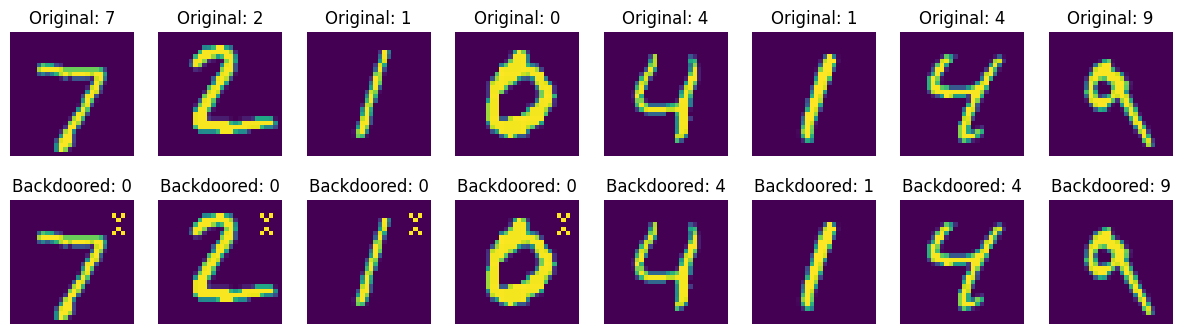

In [15]:
import matplotlib.pyplot as plt
import numpy as np

images_to_show = 8
# Define the function for displaying an image
def imshow(img, ax, title=""):
    # img is a torch.Tensor
    img = img.cpu().numpy().transpose((1, 2, 0))  # Convert to numpy format and change order to HxWxC
    # Undo normalization
    mean = np.array([0.1307])
    std = np.array([0.3081])
    img = std * img + mean  # This line undoes the normalization applied to the images
    img = np.clip(img, 0, 1)  # Ensure the image's values are between 0 and 1 so plt can plot it correctly
    ax.imshow(img)
    if title:
        ax.set_title(title)
    ax.axis('off')

# Create figure with subplots
fig, axs = plt.subplots(2, images_to_show, figsize=(15, 4))

# Display original images
for i in range(images_to_show):
    imshow(test_batch.inputs[i], axs[0, i], f"Original: {test_batch.labels[i].item()}")

# Display backdoored images
for i in range(images_to_show):
    imshow(backdoored_batch.inputs[i], axs[1, i], f"Backdoored: {backdoored_batch.labels[i].item()}")

plt.show()


In [16]:
class AttackerBackdoor(GradWeightClient):
    def train_epoch(self, model: torch.nn.Module, loader: DataLoader, optimizer: Optimizer) -> None:
        model.train()
        for batch_idx, (inputs, labels) in enumerate(loader):
            batch = Batch(batch_idx, inputs, labels)
            batch = batch.to(device)
            backdoored_batch = synthesizer.make_backdoor_batch(batch, test=False, attack=True)
            data = backdoored_batch.inputs
            target = backdoored_batch.labels
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

    def update(self, weights: list[torch.Tensor], seed: int) -> list[torch.Tensor]:
        # Load the server weights into the model
        with torch.no_grad():
            for client_values, server_values in zip(self.model.parameters(), weights):
                client_values[:] = server_values

        self.generator.manual_seed(seed)

        # Save initial weights to calculate the gradients later
        initial_weights = [param.clone() for param in self.model.parameters()]

        for _epoch in range(self.nr_epochs):
            self.train_epoch(self.model, self.loader_train, self.optimizer)

        # Calculate gradients: final_weights - initial_weights
        gradients = [5*(initial_weight - final_weight) for final_weight, initial_weight in zip(self.model.parameters(), initial_weights)]

        return [gradient.detach().cpu().clone() for gradient in gradients]

In [17]:
fedavg_server_backdoor = FedAvgGradServer(0.02, 200, sample_split, 0.2, 2, 42)
clients = fedavg_server_backdoor.clients
# Number of clients to be made malicious with backdoor
num_malicious = int(0.2 * len(clients))  # For example, 20%
# Randomly select indices for the clients to undergo backdoor attack
malicious_indices = np.random.choice(len(clients), num_malicious, replace=False)

# Replace the selected clients with instances of AttackerGradientInversion
for idx in malicious_indices:
    client_data = clients[idx].loader_train.dataset
    lr = clients[idx].optimizer.param_groups[0]['lr']
    batch_size = clients[idx].loader_train.batch_size
    nr_epochs = clients[idx].nr_epochs
    clients[idx] = AttackerBackdoor(client_data, lr, batch_size, nr_epochs)

result_fedavg_backdoor = fedavg_server_backdoor.run(10)
fedavg_df_backdoor = result_fedavg_backdoor.as_df()
fedavg_df_backdoor

,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,FedAvg,100,0.2,200,2,0.02,42,40,9.80
1,2,FedAvg,100,0.2,200,2,0.02,42,80,9.80
2,3,FedAvg,100,0.2,200,2,0.02,42,120,31.92
3,4,FedAvg,100,0.2,200,2,0.02,42,160,63.21
4,5,FedAvg,100,0.2,200,2,0.02,42,200,75.64
5,6,FedAvg,100,0.2,200,2,0.02,42,240,78.34
6,7,FedAvg,100,0.2,200,2,0.02,42,280,81.32
7,8,FedAvg,100,0.2,200,2,0.02,42,320,83.02
8,9,FedAvg,100,0.2,200,2,0.02,42,360,82.74
9,10,FedAvg,100,0.2,200,2,0.02,42,400,85.58


From the previous results, we can find that the global test acuracy are not influnced by the backdoor attacks too much. That's beacuse all of the test data are without trigger. Now let's add trigger to our dataset.

In [18]:
def confusion_matrix_backdoor(model, test_loader: DataLoader, num_classes: int) -> (float, np.ndarray):
    correct = 0
    success = 0
    model.eval()
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.int64)

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader):
            batch = Batch(batch_idx, inputs, labels)
            batch = batch.to(device)
            backdoored_batch = synthesizer.make_backdoor_batch(batch, test=True, attack=True)
            data = backdoored_batch.inputs
            target = backdoored_batch.labels
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct +=  pred.eq(batch.labels.view_as(pred)).sum().item()
            success += pred.eq(target.view_as(pred)).sum().item()

            # Update confusion matrix
            for t, p in zip(batch.labels.view(-1), pred.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    accuracy = 100. * correct / len(test_loader.dataset)
    success_rate = 100. * success / len(test_loader.dataset)
    return accuracy, success_rate, confusion_matrix

accuracy, success_rate, confusion_matrix = confusion_matrix_backdoor(fedavg_server_backdoor.model, test_loader, 10)
print(f'The global test accuracy is {accuracy}%')
print(f'The attack success_rate is {success_rate}%')

The global test accuracy is 10.19%
The attack success_rate is 99.6%


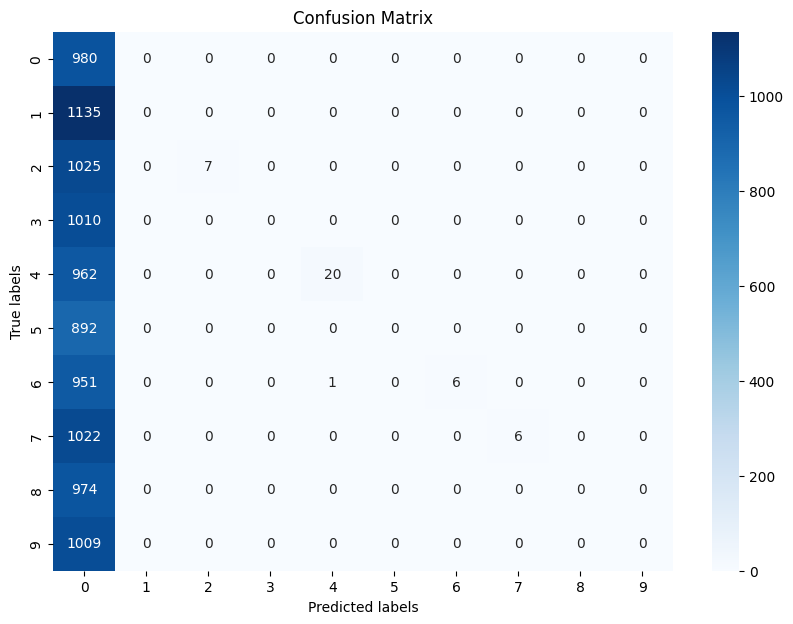

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
plot_confusion_matrix(confusion_matrix, class_names=[str(i) for i in range(10)])

# Tutorial 3B


## Krum and Multi-Krum
Krum is a robust aggregation algorithm designed to enhance the reliability of distributed systems, especially in settings like federated learning where multiple workers or agents contribute updates. Developed to combat Byzantine faults, wherein some participants may be unreliable or malicious, Krum evaluates each worker's update by calculating its squared $l_2$ norm distance to the majority of other updates. For each update $\Delta_i$, Krum defines a neighbor set $\mathcal{S}$ consisting of its $n-m-2$ nearest updates and assigns a score based on:
$$
\sum_{j \in \mathcal{S}} \left\|\Delta_i - \Delta_j\right\|_2^2
$$
The update $\Delta_i$ with the lowest score is selected as the most trustworthy. This methodology effectively filters out anomalous updates caused by up to $m$ Byzantine workers, ensuring the aggregation process remains secure and robust against adversarial attacks.


In [20]:
def krum(clients_updates, n=20, m=4):
    # Number of neighboring updates to consider
    n_neighbors = n - m - 2
    scores = []

    # Calculate the score for each update
    for i in range(len(clients_updates)):
        distances = []
        for j in range(len(clients_updates)):
            if i != j:
                # Compute squared l2 distance between updates
                distance = sum((param_i - param_j).pow(2).sum()
                               for param_i, param_j in zip(clients_updates[i][1], clients_updates[j][1]))
                distances.append(distance)

        # Get the n_neighbors smallest distances
        nearest_distances = sorted(distances)[:n_neighbors]
        # Sum of these distances is the score of this client's update
        scores.append(sum(nearest_distances))

    # Select the index with the smallest score
    selected_index = scores.index(min(scores))
    return [selected_index]

class FedAvgServerDefense(FedAvgGradServer):
    def __init__(self, lr: float, batch_size: int, client_subsets: list, client_fraction: float, nr_local_epochs: int, seed: int, defense=None):
        super().__init__(lr, batch_size, client_subsets, client_fraction, nr_local_epochs, seed)
        self.defense_method = defense

    def run(self, nr_rounds: int) -> RunResult:
        # The beginning of the method remains unchanged
        elapsed_time = 0.
        run_result = RunResult(self.name, self.nr_clients, self.client_fraction, self.batch_size, self.nr_local_epochs, self.lr, self.seed)

        # Initial server weights
        server_weights = [param.data.clone() for param in self.model.parameters()]
        for nr_round in tqdm(range(nr_rounds), desc="Rounds", leave=False):
            setup_start_time = perf_counter()
            self.model.train()
            weights = [x.detach().cpu().clone() for x in self.model.parameters()]
            indices_chosen_clients = self.rng.choice(self.nr_clients, self.nr_clients_per_round, replace=False)
            chosen_sum_nr_samples = sum(self.client_sample_counts[i] for i in indices_chosen_clients)
            chosen_adjusted_weights: list[list[torch.Tensor]] = []
            elapsed_time += perf_counter() - setup_start_time
            update_time = 0.

            client_updates = []  # Store (client_index, updates) tuples
            for c_i in indices_chosen_clients:
                update_start_time = perf_counter()
                ind = int(c_i)
                client_round_seed = self.seed + ind + 1 + nr_round * self.nr_clients_per_round
                client_weights = self.clients[ind].update(weights, client_round_seed)
                client_updates.append((ind, client_weights))
                update_time = max(update_time, perf_counter() - update_start_time)
            if self.defense_method:
                selected_indices = self.defense_method(client_updates)
            else:
                selected_indices = range(len(client_updates))  # Use all updates if no defense is specified
            print(f'The following indices are selected in the training {np.sort(indices_chosen_clients[selected_indices])}')
            chosen_sum_nr_samples = sum(self.client_sample_counts[i] for i in indices_chosen_clients[selected_indices])
            chosen_adjusted_weights = [
                [self.client_sample_counts[indices_chosen_clients[ind]] / chosen_sum_nr_samples * tens for tens in client_updates[ind][1]]
                for ind in selected_indices
            ]
            # Aggregation logic remains the same from this point onwards
            # Note that chosen_adjusted_weights now only contains updates from clients selected by multi_krum
            elapsed_time += update_time
            aggregate_start_time = perf_counter()
            averaged_gradients: list[torch.Tensor] = [sum(x) for x in zip(*chosen_adjusted_weights)]

            # Update server model with averaged gradients
            with torch.no_grad():
                for server_weight, gradient in zip(server_weights, averaged_gradients):
                    server_weight -= gradient.to(device=device)  # Assume learning rate is absorbed in gradient

            # Distribute updated weights to clients
            with torch.no_grad():
                for param, server_weight in zip(self.model.parameters(), server_weights):
                    param.data[:] = server_weight.data


            elapsed_time += perf_counter() - aggregate_start_time
            run_result.wall_time.append(round(elapsed_time, 1))
            run_result.message_count.append(2 * (nr_round + 1) * self.nr_clients_per_round)
            run_result.test_accuracy.append(self.test())

        return run_result

In [21]:
# malicious clients
class AttackerGradientReversion(GradWeightClient):
    def update(self, weights: list[torch.Tensor], seed: int) -> list[torch.Tensor]:
        # Call the base implementation to perform the normal training and update process
        honest_gradients = super().update(weights, seed)

        # Reverse the gradients: for a malicious client, negate the weights to simulate an attack
        reversed_gradients = [-5*w for w in honest_gradients]

        return reversed_gradients

fedavg_server = FedAvgServerDefense(0.02, 200, sample_split, 0.2, 2, 42, defense=krum)
clients = fedavg_server.clients
# Number of clients to be made malicious with gradient reversion
num_malicious = int(0.20 * len(clients))  # For example, 20%
# Randomly select indices for the clients to undergo gradient inversion attack
malicious_indices = np.random.choice(len(clients), num_malicious, replace=False)
# Replace the selected clients with instances of AttackerGradientInversion
print(f'the following is the malicious indices: {np.sort(malicious_indices)}')
for idx in malicious_indices:
    client_data = clients[idx].loader_train.dataset
    lr = clients[idx].optimizer.param_groups[0]['lr']
    batch_size = clients[idx].loader_train.batch_size
    nr_epochs = clients[idx].nr_epochs
    clients[idx] = AttackerGradientReversion(client_data, lr, batch_size, nr_epochs)

result_fedavg_krum = fedavg_server.run(10)
fedavg_df_krum = result_fedavg_krum.as_df()
fedavg_df_krum

the following is the malicious indices: [ 8 20 24 29 43 44 48 49 61 62 67 68 72 73 74 75 76 79 84 87]


Rounds:   0%|          | 0/10 [00:00<?, ?it/s]

The following indices are selected in the training [63]


Rounds:  10%|█         | 1/10 [00:02<00:23,  2.57s/it]

The following indices are selected in the training [30]


Rounds:  20%|██        | 2/10 [00:05<00:21,  2.63s/it]

The following indices are selected in the training [28]


Rounds:  30%|███       | 3/10 [00:07<00:18,  2.65s/it]

The following indices are selected in the training [69]


Rounds:  40%|████      | 4/10 [00:10<00:15,  2.63s/it]

The following indices are selected in the training [65]


Rounds:  50%|█████     | 5/10 [00:13<00:12,  2.59s/it]

The following indices are selected in the training [77]


Rounds:  60%|██████    | 6/10 [00:15<00:10,  2.57s/it]

The following indices are selected in the training [70]


Rounds:  70%|███████   | 7/10 [00:18<00:07,  2.56s/it]

The following indices are selected in the training [54]


Rounds:  80%|████████  | 8/10 [00:20<00:05,  2.57s/it]

The following indices are selected in the training [22]


Rounds:  90%|█████████ | 9/10 [00:23<00:02,  2.56s/it]

The following indices are selected in the training [13]


,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,FedAvg,100,0.2,200,2,0.02,42,40,31.26
1,2,FedAvg,100,0.2,200,2,0.02,42,80,45.39
2,3,FedAvg,100,0.2,200,2,0.02,42,120,64.49
3,4,FedAvg,100,0.2,200,2,0.02,42,160,72.54
4,5,FedAvg,100,0.2,200,2,0.02,42,200,71.68
5,6,FedAvg,100,0.2,200,2,0.02,42,240,80.68
6,7,FedAvg,100,0.2,200,2,0.02,42,280,81.77
7,8,FedAvg,100,0.2,200,2,0.02,42,320,83.69
8,9,FedAvg,100,0.2,200,2,0.02,42,360,83.40
9,10,FedAvg,100,0.2,200,2,0.02,42,400,86.44


Multi-Krum extends the robustness of Krum by incorporating multiple potential updates into the final aggregation, instead of selecting just a single update. This adaptation is especially beneficial in environments where higher degrees of fault tolerance and diversity in accepted updates are needed. 

-Initialize: Start with a list of updates and parameters for the number of updates to select (k), total updates (n), and estimate malicious updates (m).

-Iterate to Select: For each of the k selections, apply Krum to find the best update, remove it from the list, and record its original index.

-Output: Return the indices of these selected updates.


In [22]:
def multi_krum(clients_updates, k=14, n=20, m=5):
    selected_indices = []
    remaining_updates = clients_updates[:]

    for i in range(k):
        # Apply Krum to the remaining updates and get the index of the best gradient
        selected_index = krum(remaining_updates,n-i,m)[0]

        # Map selected index from remaining_updates back to the original clients_updates
        original_index = clients_updates.index(remaining_updates[selected_index])
        selected_indices.append(original_index)

        # Remove the selected update from remaining_updates
        remaining_updates.pop(selected_index)

    return selected_indices

In [23]:
# malicious clients
class AttackerGradientReversion(GradWeightClient):
    def update(self, weights: list[torch.Tensor], seed: int) -> list[torch.Tensor]:
        # Call the base implementation to perform the normal training and update process
        honest_gradients = super().update(weights, seed)

        # Reverse the gradients: for a malicious client, negate the weights to simulate an attack
        reversed_gradients = [-5*w for w in honest_gradients]

        return reversed_gradients

fedavg_server = FedAvgServerDefense(0.02, 200, sample_split, 0.2, 2, 42, defense=multi_krum)
clients = fedavg_server.clients
# Number of clients to be made malicious with gradient reversion
num_malicious = int(0.20 * len(clients))  # For example, 20%
# Randomly select indices for the clients to undergo gradient inversion attack
malicious_indices = np.random.choice(len(clients), num_malicious, replace=False)
print(f'The following is the malicious indices: {np.sort(malicious_indices)}')
# Replace the selected clients with instances of AttackerGradientInversion
for idx in malicious_indices:
    client_data = clients[idx].loader_train.dataset
    lr = clients[idx].optimizer.param_groups[0]['lr']
    batch_size = clients[idx].loader_train.batch_size
    nr_epochs = clients[idx].nr_epochs
    clients[idx] = AttackerGradientReversion(client_data, lr, batch_size, nr_epochs)

result_fedavg_multi_krum = fedavg_server.run(10)
fedavg_df_multi_krum = result_fedavg_multi_krum.as_df()
fedavg_df_multi_krum

The following is the malicious indices: [ 9 10 11 13 17 24 34 35 40 55 56 57 59 62 70 80 81 82 83 87]


Rounds:   0%|          | 0/10 [00:00<?, ?it/s]

The following indices are selected in the training [12 36 49 54 61 63 68 71 73 75 84 86 89 94]


Rounds:  10%|█         | 1/10 [00:03<00:32,  3.60s/it]

The following indices are selected in the training [ 4 15 18 30 39 44 47 53 58 61 62 69 74 84]


Rounds:  20%|██        | 2/10 [00:06<00:27,  3.46s/it]

The following indices are selected in the training [ 8 23 28 36 37 54 61 68 69 71 75 76 79 97]


Rounds:  30%|███       | 3/10 [00:10<00:23,  3.37s/it]

The following indices are selected in the training [ 7  8 20 30 36 50 52 53 54 60 69 75 77 94]


Rounds:  40%|████      | 4/10 [00:13<00:20,  3.43s/it]

The following indices are selected in the training [ 2  8 10 15 29 31 37 41 46 65 73 74 84 94]


Rounds:  50%|█████     | 5/10 [00:17<00:17,  3.45s/it]

The following indices are selected in the training [ 7 25 28 41 43 44 62 69 73 77 79 90 93 99]


Rounds:  60%|██████    | 6/10 [00:20<00:13,  3.43s/it]

The following indices are selected in the training [ 7  8 17 18 26 32 36 39 51 53 58 74 89 93]


Rounds:  70%|███████   | 7/10 [00:23<00:10,  3.37s/it]

The following indices are selected in the training [ 5  7 26 39 40 43 44 45 52 54 77 79 91 95]


Rounds:  80%|████████  | 8/10 [00:27<00:06,  3.37s/it]

The following indices are selected in the training [13 20 21 22 23 28 37 54 84 85 89 90 92 98]


Rounds:  90%|█████████ | 9/10 [00:30<00:03,  3.36s/it]

The following indices are selected in the training [ 2  3 20 30 33 36 45 49 66 76 77 83 84 98]


,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,FedAvg,100,0.2,200,2,0.02,42,40,20.29
1,2,FedAvg,100,0.2,200,2,0.02,42,80,35.23
2,3,FedAvg,100,0.2,200,2,0.02,42,120,65.09
3,4,FedAvg,100,0.2,200,2,0.02,42,160,73.43
4,5,FedAvg,100,0.2,200,2,0.02,42,200,71.80
5,6,FedAvg,100,0.2,200,2,0.02,42,240,76.39
6,7,FedAvg,100,0.2,200,2,0.02,42,280,76.62
7,8,FedAvg,100,0.2,200,2,0.02,42,320,80.33
8,9,FedAvg,100,0.2,200,2,0.02,42,360,80.59
9,10,FedAvg,100,0.2,200,2,0.02,42,400,82.85


## Median and Trimmed-mean

The attacker can bypass Krum and Multi-Krum algorithms by subtly altering only a small subset of gradient components. Due to the high dimensionality of the gradients, these small changes result in minimal overall differences in distance, making the malicious updates appear benign. 

In [24]:
class AttackerPartGradientReversion(GradWeightClient):
    def update(self, weights: list[torch.Tensor], seed: int) -> list[torch.Tensor]:
        # Set random seed for reproducibility
        torch.manual_seed(seed)

        # Call the base implementation to perform the normal training and update process
        honest_gradients = super().update(weights, seed)

        # Flatten the gradients and calculate 10% of the total number of gradient elements
        all_gradients = torch.cat([g.flatten() for g in honest_gradients])
        num_to_manipulate = int(all_gradients.numel())

        # Determine the threshold of parameters to modify
        param_threshold = num_to_manipulate*0.00001  # Set this to your desired threshold

        # Select the first k layers until the cumulative number of parameters exceeds the threshold
        cumulative_params = 0
        selected_gradients = []
        for gradient in honest_gradients:
            #print(gradient.numel())
            cumulative_params += gradient.numel()
            selected_gradients.append(gradient)
            if cumulative_params >= param_threshold:
                break

        # Multiply the selected gradients by -1000
        for gradient in selected_gradients:
            gradient *= -1000

        return honest_gradients  # Return the modified gradients

fedavg_server = FedAvgServerDefense(0.02, 200, sample_split, 0.2, 2, 42, defense=multi_krum)
clients = fedavg_server.clients
# Number of clients to be made malicious with gradient reversion
num_malicious = int(0.20 * len(clients))  # For example, 20%
# Randomly select indices for the clients to undergo gradient inversion attack
malicious_indices = np.random.choice(len(clients), num_malicious, replace=False)
print(f'The following is the malicious indices: {np.sort(malicious_indices)}')
# Replace the selected clients with instances of AttackerGradientInversion
for idx in malicious_indices:
    client_data = clients[idx].loader_train.dataset
    lr = clients[idx].optimizer.param_groups[0]['lr']
    batch_size = clients[idx].loader_train.batch_size
    nr_epochs = clients[idx].nr_epochs
    clients[idx] = AttackerPartGradientReversion(client_data, lr, batch_size, nr_epochs)

result_fedavg_part = fedavg_server.run(10)
fedavg_df_part = result_fedavg_part.as_df()
fedavg_df_part

The following is the malicious indices: [ 5 22 25 26 27 28 32 34 39 41 46 48 49 54 55 56 62 67 86 99]


Rounds:   0%|          | 0/10 [00:00<?, ?it/s]

The following indices are selected in the training [ 8 12 17 36 47 61 63 71 73 75 83 84 89 94]


Rounds:  10%|█         | 1/10 [00:03<00:32,  3.59s/it]

The following indices are selected in the training [ 4 13 15 18 30 44 53 58 61 62 69 70 79 84]


Rounds:  20%|██        | 2/10 [00:07<00:28,  3.51s/it]

The following indices are selected in the training [ 8 13 36 37 40 45 61 68 69 71 75 79 87 97]


Rounds:  30%|███       | 3/10 [00:10<00:24,  3.44s/it]

The following indices are selected in the training [ 7  8 11 20 30 40 50 53 59 60 69 75 77 85]


Rounds:  40%|████      | 4/10 [00:13<00:20,  3.43s/it]

The following indices are selected in the training [ 2  8 10 15 29 35 37 46 57 65 70 73 84 87]


Rounds:  50%|█████     | 5/10 [00:17<00:18,  3.69s/it]

The following indices are selected in the training [ 7  9 24 43 44 62 69 70 77 79 81 83 90 93]


Rounds:  60%|██████    | 6/10 [00:21<00:14,  3.64s/it]

The following indices are selected in the training [ 3  7 12 17 18 26 36 51 53 57 58 70 74 89]


Rounds:  70%|███████   | 7/10 [00:24<00:10,  3.53s/it]

The following indices are selected in the training [ 5 15 24 40 43 44 45 52 66 77 79 87 91 95]


Rounds:  80%|████████  | 8/10 [00:28<00:07,  3.51s/it]

The following indices are selected in the training [ 3  9 13 20 21 23 37 54 81 84 85 89 90 92]


Rounds:  90%|█████████ | 9/10 [00:31<00:03,  3.47s/it]

The following indices are selected in the training [ 2 10 13 24 30 36 49 66 76 77 81 83 84 98]


,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,FedAvg,100,0.2,200,2,0.02,42,40,21.31
1,2,FedAvg,100,0.2,200,2,0.02,42,80,10.16
2,3,FedAvg,100,0.2,200,2,0.02,42,120,32.29
3,4,FedAvg,100,0.2,200,2,0.02,42,160,53.04
4,5,FedAvg,100,0.2,200,2,0.02,42,200,12.32
5,6,FedAvg,100,0.2,200,2,0.02,42,240,18.14
6,7,FedAvg,100,0.2,200,2,0.02,42,280,11.32
7,8,FedAvg,100,0.2,200,2,0.02,42,320,11.40
8,9,FedAvg,100,0.2,200,2,0.02,42,360,40.36
9,10,FedAvg,100,0.2,200,2,0.02,42,400,1.25


Coordinate-wise median focus on the statistical performance of the robust aggregation methods. It sorts the values $f$ this dimension of all gradients and uses the median as the nal aggregation of the values. Here, we use $[\boldsymbol{v}]_j$ to denote e $j_{t h}$ coordinate of vector $v$. And $n$ is the number of clients elected in a round. The coordinate-wise median is defined as
$$
\left[\mathrm{CM}\left(\Delta_1, \ldots, \Delta_n\right)\right]_j=\operatorname{median}\left(\left[\Delta_1\right]_j, \ldots,\left[\Delta_n\right]_j\right)
$$

In [25]:
def median(gradients):
    # Transpose the list of lists to group gradients of the same parameter together
    parameter_wise_gradients = list(zip(*gradients))
    # Calculate median for each parameter
    median_gradients = []
    for parameter_group in parameter_wise_gradients:
        # Stack gradients to create a new dimension corresponding to clients
        stacked_gradients = torch.stack(parameter_group, dim=0)

        # Compute the median along the client dimension (dim=0)
        median_gradient = torch.median(stacked_gradients, dim=0).values
        median_gradients.append(median_gradient*20)

    return median_gradients

class FedAvgServerDefenseCoordinate(FedAvgGradServer):
    def __init__(self, lr: float, batch_size: int, client_subsets: list, client_fraction: float, nr_local_epochs: int, seed: int, defense=None):
        super().__init__(lr, batch_size, client_subsets, client_fraction, nr_local_epochs, seed)
        self.defense_method = defense

    def run(self, nr_rounds: int) -> RunResult:
        # The beginning of the method remains unchanged
        elapsed_time = 0.
        run_result = RunResult(self.name, self.nr_clients, self.client_fraction, self.batch_size, self.nr_local_epochs, self.lr, self.seed)

        # Initial server weights
        server_weights = [param.data.clone() for param in self.model.parameters()]
        for nr_round in tqdm(range(nr_rounds), desc="Rounds", leave=False):
            setup_start_time = perf_counter()
            self.model.train()
            weights = [x.detach().cpu().clone() for x in self.model.parameters()]
            indices_chosen_clients = self.rng.choice(self.nr_clients, self.nr_clients_per_round, replace=False)
            chosen_sum_nr_samples = sum(self.client_sample_counts[i] for i in indices_chosen_clients)
            chosen_adjusted_weights: list[list[torch.Tensor]] = []
            elapsed_time += perf_counter() - setup_start_time
            update_time = 0.

            client_updates = []  # Store (client_index, updates) tuples
            for c_i in indices_chosen_clients:
                update_start_time = perf_counter()
                ind = int(c_i)
                client_round_seed = self.seed + ind + 1 + nr_round * self.nr_clients_per_round
                client_weights = self.clients[ind].update(weights, client_round_seed)
                chosen_adjusted_weights.append([
                    self.client_sample_counts[ind] / chosen_sum_nr_samples * tens
                     for tens in client_weights])
                update_time = max(update_time, perf_counter() - update_start_time)

            elapsed_time += update_time
            aggregate_start_time = perf_counter()
            if self.defense_method:
                averaged_gradients = self.defense_method(chosen_adjusted_weights)
            else:
                averaged_gradients: list[torch.Tensor] = [sum(x) for x in zip(*chosen_adjusted_weights)]


            # Update server model with averaged gradients
            with torch.no_grad():
                for server_weight, gradient in zip(server_weights, averaged_gradients):
                    server_weight -= gradient.to(device=device)  # Assume learning rate is absorbed in gradient

            # Distribute updated weights to clients
            with torch.no_grad():
                for param, server_weight in zip(self.model.parameters(), server_weights):
                    param.data[:] = server_weight.data


            elapsed_time += perf_counter() - aggregate_start_time
            run_result.wall_time.append(round(elapsed_time, 1))
            run_result.message_count.append(2 * (nr_round + 1) * self.nr_clients_per_round)
            run_result.test_accuracy.append(self.test())

        return run_result

In [26]:
fedavg_server = FedAvgServerDefenseCoordinate(0.02, 200, sample_split, 0.2, 2, 42, defense=median)
clients = fedavg_server.clients
# Number of clients to be made malicious with gradient reversion
num_malicious = int(0.20 * len(clients))  # For example, 20%
# Randomly select indices for the clients to undergo gradient inversion attack
malicious_indices = np.random.choice(len(clients), num_malicious, replace=False)
print(malicious_indices)
# Replace the selected clients with instances of AttackerGradientInversion
for idx in malicious_indices:
    client_data = clients[idx].loader_train.dataset
    lr = clients[idx].optimizer.param_groups[0]['lr']
    batch_size = clients[idx].loader_train.batch_size
    nr_epochs = clients[idx].nr_epochs
    clients[idx] = AttackerPartGradientReversion(client_data, lr, batch_size, nr_epochs)

result_fedavg_reverse = fedavg_server.run(10)
fedavg_df_reverse = result_fedavg_reverse.as_df()
fedavg_df_reverse

[20 91 54 88 30 67 48 82 76 11 62 41 94 61 74 29 63 77 34 17]


,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,FedAvg,100,0.2,200,2,0.02,42,40,22.28
1,2,FedAvg,100,0.2,200,2,0.02,42,80,53.40
2,3,FedAvg,100,0.2,200,2,0.02,42,120,67.24
3,4,FedAvg,100,0.2,200,2,0.02,42,160,74.71
4,5,FedAvg,100,0.2,200,2,0.02,42,200,76.62
5,6,FedAvg,100,0.2,200,2,0.02,42,240,81.17
6,7,FedAvg,100,0.2,200,2,0.02,42,280,82.38
7,8,FedAvg,100,0.2,200,2,0.02,42,320,84.29
8,9,FedAvg,100,0.2,200,2,0.02,42,360,85.51
9,10,FedAvg,100,0.2,200,2,0.02,42,400,87.08


 Coordinate-wise trimmed mean is similar to the coordinate-wise median. It sorts the values of this dimension of all gradients. Then it removes the top and bottom $\beta$ values and computes the averages of the rest of the values as its aggregate of this dimension. Coordinate-wise trimmed mean is defined as:
$$
\left[\operatorname{TM}\left(\Delta_1, \ldots, \Delta_n\right)\right]_j=\frac{1}{n-2 \beta} \sum_{i=\beta}^{n-\beta}\left[\Delta_{\Pi_j(i)}\right]_j
$$


In [27]:
def tr_mean(all_updates, beta=0.4):
    # 'n_attackers' is the number of top and bottom values to exclude from the mean calculation.

    # Transpose the list to group gradients of the same parameter together
    parameter_wise_updates = list(zip(*all_updates))
    n_attackers = int(20*beta)
    trimmed_mean_gradients = []
    for parameter_group in parameter_wise_updates:
        # Stack gradients to create a new dimension corresponding to clients
        stacked_updates = torch.stack(parameter_group, dim=0)

        # Sort updates along the client dimension
        sorted_updates = torch.sort(stacked_updates, dim=0)[0]
        # Compute mean excluding the top and bottom 'n_attackers' updates
        if n_attackers > 0:
            trimmed_updates = sorted_updates[n_attackers:-n_attackers]
        else:
            trimmed_updates = sorted_updates

        mean_gradient = torch.mean(trimmed_updates, dim=0)
        trimmed_mean_gradients.append(mean_gradient*20)

    return trimmed_mean_gradients

In [28]:
fedavg_server = FedAvgServerDefenseCoordinate(0.02, 200, sample_split, 0.2, 2, 42, defense=tr_mean)
clients = fedavg_server.clients
num_malicious = int(0.20 * len(clients))  # For example, 20%
# Randomly select indices for the clients to undergo gradient inversion attack
malicious_indices = np.random.choice(len(clients), num_malicious, replace=False)
print(malicious_indices)
for idx in malicious_indices:
    client_data = clients[idx].loader_train.dataset
    lr = clients[idx].optimizer.param_groups[0]['lr']
    batch_size = clients[idx].loader_train.batch_size
    nr_epochs = clients[idx].nr_epochs
    clients[idx] = AttackerPartGradientReversion(client_data, lr, batch_size, nr_epochs)

result_fedavg_reverse = fedavg_server.run(10)
fedavg_df_reverse = result_fedavg_reverse.as_df()
fedavg_df_reverse

[30 20  7 44 64 18 55 65 86 39 53 28 14 78 81 75 71 45 10 72]


,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,FedAvg,100,0.2,200,2,0.02,42,40,20.92
1,2,FedAvg,100,0.2,200,2,0.02,42,80,51.93
2,3,FedAvg,100,0.2,200,2,0.02,42,120,66.36
3,4,FedAvg,100,0.2,200,2,0.02,42,160,74.36
4,5,FedAvg,100,0.2,200,2,0.02,42,200,76.38
5,6,FedAvg,100,0.2,200,2,0.02,42,240,81.00
6,7,FedAvg,100,0.2,200,2,0.02,42,280,82.62
7,8,FedAvg,100,0.2,200,2,0.02,42,320,84.24
8,9,FedAvg,100,0.2,200,2,0.02,42,360,84.52
9,10,FedAvg,100,0.2,200,2,0.02,42,400,87.04


## Majority Sign 
This Majority Sign enhances model robustness by focusing on the consensus in the direction of parameter updates, rather than their magnitudes. The key principle behind this method is the use of sign aggregation to determine the majority or dominant direction of updates across all participating clients. By evaluating only the sign of each gradient component, the algorithm effectively filters out anomalies and aligns the updates toward the most commonly agreed direction.



In [29]:
def majority_sign_filter(all_updates):
    # 'all_updates' is a list of lists of torch.Tensor objects,
    # where each inner list contains the gradients for all parameters from one client.

    # Step 1: Transpose the list to group gradients of the same parameter together
    parameter_wise_updates = list(zip(*all_updates))

    # Step 2: Calculate sign and count for determining majority
    all_signs = [torch.sign(torch.stack(parameter_group, dim=0)) for parameter_group in parameter_wise_updates]

    # Step 3: Determine the majority sign for each parameter coordinate
    majority_signs = [torch.sign(torch.sum(signs, dim=0)) for signs in all_signs]

    # Step 4: Filter out gradients whose signs don't match the majority
    filtered_updates = []
    for idx, parameter_group in enumerate(parameter_wise_updates):
        majority_sign = majority_signs[idx]
        zeroed_gradients = []

        for gradient in parameter_group:
            gradient_signs = torch.sign(gradient)
            # Zero out gradients where the sign does not match the majority
            gradient[gradient_signs != majority_sign] = 0
            zeroed_gradients.append(gradient)

        # Step 5: Calculate the average of the filtered gradients
        filtered_average = torch.mean(torch.stack(zeroed_gradients), dim=0)
        filtered_updates.append(filtered_average*20)

    return filtered_updates


In [30]:
class AttackerBackdoor(GradWeightClient):
    def train_epoch(self, model: torch.nn.Module, loader: DataLoader, optimizer: Optimizer) -> None:
        model.train()
        for batch_idx, (inputs, labels) in enumerate(loader):
            batch = Batch(batch_idx, inputs, labels)
            batch = batch.to(device)
            backdoored_batch = synthesizer.make_backdoor_batch(batch, test=False, attack=True)
            data = backdoored_batch.inputs
            target = backdoored_batch.labels
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

    def update(self, weights: list[torch.Tensor], seed: int) -> list[torch.Tensor]:
        # Load the server weights into the model
        with torch.no_grad():
            for client_values, server_values in zip(self.model.parameters(), weights):
                client_values[:] = server_values

        self.generator.manual_seed(seed)

        # Save initial weights to calculate the gradients later
        initial_weights = [param.clone() for param in self.model.parameters()]

        for _epoch in range(self.nr_epochs):
            self.train_epoch(self.model, self.loader_train, self.optimizer)

        # Calculate gradients: final_weights - initial_weights
        gradients = [2*(initial_weight - final_weight) for final_weight, initial_weight in zip(self.model.parameters(), initial_weights)]

        return [gradient.detach().cpu().clone() for gradient in gradients]

In [31]:
fedavg_server_backdoor = FedAvgServerDefenseCoordinate(0.02, 200, sample_split, 0.2, 2, 42, defense=majority_sign_filter)
clients = fedavg_server_backdoor.clients
# Number of clients to be made malicious with backdoor
num_malicious = int(0.2 * len(clients))  # For example, 20%
# Randomly select indices for the clients to undergo backdoor attack
malicious_indices = np.random.choice(len(clients), num_malicious, replace=False)
print(malicious_indices)
# Replace the selected clients with instances of AttackerGradientInversion
for idx in malicious_indices:
    client_data = clients[idx].loader_train.dataset
    lr = clients[idx].optimizer.param_groups[0]['lr']
    batch_size = clients[idx].loader_train.batch_size
    nr_epochs = clients[idx].nr_epochs
    clients[idx] = AttackerBackdoor(client_data, lr, batch_size, nr_epochs)

result_fedavg_backdoor = fedavg_server_backdoor.run(10)
fedavg_df_backdoor = result_fedavg_backdoor.as_df()
fedavg_df_backdoor

[35 83 77 68 55 85 47 13 51 82 58 63 86 18  4 89 30 76 45 87]


,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,FedAvg,100,0.2,200,2,0.02,42,40,9.80
1,2,FedAvg,100,0.2,200,2,0.02,42,80,9.80
2,3,FedAvg,100,0.2,200,2,0.02,42,120,29.67
3,4,FedAvg,100,0.2,200,2,0.02,42,160,69.95
4,5,FedAvg,100,0.2,200,2,0.02,42,200,73.93
5,6,FedAvg,100,0.2,200,2,0.02,42,240,81.16
6,7,FedAvg,100,0.2,200,2,0.02,42,280,80.32
7,8,FedAvg,100,0.2,200,2,0.02,42,320,84.89
8,9,FedAvg,100,0.2,200,2,0.02,42,360,84.69
9,10,FedAvg,100,0.2,200,2,0.02,42,400,86.11


In [32]:
accuracy, success_rate, confusion_matrix = confusion_matrix_backdoor(fedavg_server_backdoor.model, test_loader, 10)
print(f'The global test accuracy is {accuracy}%')
print(f'The attack success_rate is {success_rate}%')

The global test accuracy is 81.81%
The attack success_rate is 17.12%


In [33]:
# malicious clients
class AttackerGradientReversion(GradWeightClient):
    def update(self, weights: list[torch.Tensor], seed: int) -> list[torch.Tensor]:
        # Call the base implementation to perform the normal training and update process
        honest_gradients = super().update(weights, seed)

        # Reverse the gradients: for a malicious client, negate the weights to simulate an attack
        reversed_gradients = [-5*w for w in honest_gradients]

        return reversed_gradients

fedavg_server = FedAvgServerDefenseCoordinate(0.02, 200, sample_split, 0.2, 2, 42, defense=majority_sign_filter)
clients = fedavg_server.clients
# Number of clients to be made malicious with gradient reversion
num_malicious = int(0.20 * len(clients))  # For example, 20%
# Randomly select indices for the clients to undergo gradient inversion attack
malicious_indices = np.random.choice(len(clients), num_malicious, replace=False)
print(malicious_indices)
# Replace the selected clients with instances of AttackerGradientInversion
for idx in malicious_indices:
    client_data = clients[idx].loader_train.dataset
    lr = clients[idx].optimizer.param_groups[0]['lr']
    batch_size = clients[idx].loader_train.batch_size
    nr_epochs = clients[idx].nr_epochs
    clients[idx] = AttackerGradientReversion(client_data, lr, batch_size, nr_epochs)

result_fedavg_reverse = fedavg_server.run(10)
fedavg_df_reverse = result_fedavg_reverse.as_df()
fedavg_df_reverse

[92 70 81  5 22  4 34 89 32 99  0 30 33 41 52 48 39 75 51 29]


,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,FedAvg,100,0.2,200,2,0.02,42,40,22.82
1,2,FedAvg,100,0.2,200,2,0.02,42,80,43.19
2,3,FedAvg,100,0.2,200,2,0.02,42,120,63.16
3,4,FedAvg,100,0.2,200,2,0.02,42,160,71.72
4,5,FedAvg,100,0.2,200,2,0.02,42,200,74.20
5,6,FedAvg,100,0.2,200,2,0.02,42,240,78.11
6,7,FedAvg,100,0.2,200,2,0.02,42,280,80.31
7,8,FedAvg,100,0.2,200,2,0.02,42,320,81.27
8,9,FedAvg,100,0.2,200,2,0.02,42,360,80.04
9,10,FedAvg,100,0.2,200,2,0.02,42,400,85.92


## Clipping
Our previous defenses were based on majority voting. Now, we will explain a more straightforward defense that focuses on limiting the attackers' capabilities. In this method, we impose a constraint on the norm of the gradients, effectively restricting the potential impact of an attacker. By bounding these gradients, we limit the extent to which attackers can influence the model's updates.

In [34]:
def clipping(all_updates, clip_norm_ratio=1.0, noise_std_dev=0.01):
    # 'all_updates' is a list of lists of torch.Tensor objects,
    # where each inner list contains the gradients for all parameters from one client.

    # Step 1: Calculate the norm of each client's update
    norms = [torch.norm(torch.stack([torch.norm(p) for p in client_update])) for client_update in all_updates]
    average_norm = sum(norms) / len(norms) * clip_norm_ratio

    # Step 2: Clip each client's update
    clipped_updates = []
    for client_update in all_updates:
        clipped_update = []
        client_norm = torch.norm(torch.stack([torch.norm(p) for p in client_update]))
        clip_scale = min(1, average_norm / (client_norm + 1e-6))  # Avoid division by zero

        for gradient in client_update:
            clipped_gradient = gradient * clip_scale

            clipped_update.append(clipped_gradient)

        clipped_updates.append(clipped_update)

    # Step 4: Compute the average of these modified gradients
    parameter_wise_updates = list(zip(*clipped_updates))
    averaged_gradients = [torch.mean(torch.stack(parameter_group), dim=0)*20 for parameter_group in parameter_wise_updates]

    return averaged_gradients

In [35]:
# malicious clients
class AttackerGradientReversion(GradWeightClient):
    def update(self, weights: list[torch.Tensor], seed: int) -> list[torch.Tensor]:
        # Call the base implementation to perform the normal training and update process
        honest_gradients = super().update(weights, seed)

        # Reverse the gradients: for a malicious client, negate the weights to simulate an attack
        reversed_gradients = [-5*w for w in honest_gradients]

        return reversed_gradients

fedavg_server = FedAvgServerDefenseCoordinate(0.02, 200, sample_split, 0.2, 2, 42, defense=clipping)
clients = fedavg_server.clients
# Number of clients to be made malicious with gradient reversion
num_malicious = int(0.20 * len(clients))  # For example, 20%
# Randomly select indices for the clients to undergo gradient inversion attack
malicious_indices = np.random.choice(len(clients), num_malicious, replace=False)
for idx in malicious_indices:
    client_data = clients[idx].loader_train.dataset
    lr = clients[idx].optimizer.param_groups[0]['lr']
    batch_size = clients[idx].loader_train.batch_size
    nr_epochs = clients[idx].nr_epochs
    clients[idx] = AttackerGradientReversion(client_data, lr, batch_size, nr_epochs)

result_fedavg_clipping = fedavg_server.run(10)
fedavg_df_clipping = result_fedavg_clipping.as_df()
fedavg_df_clipping

,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,FedAvg,100,0.2,200,2,0.02,42,40,10.30
1,2,FedAvg,100,0.2,200,2,0.02,42,80,22.55
2,3,FedAvg,100,0.2,200,2,0.02,42,120,17.98
3,4,FedAvg,100,0.2,200,2,0.02,42,160,11.13
4,5,FedAvg,100,0.2,200,2,0.02,42,200,18.70
5,6,FedAvg,100,0.2,200,2,0.02,42,240,57.47
6,7,FedAvg,100,0.2,200,2,0.02,42,280,66.61
7,8,FedAvg,100,0.2,200,2,0.02,42,320,70.50
8,9,FedAvg,100,0.2,200,2,0.02,42,360,73.73
9,10,FedAvg,100,0.2,200,2,0.02,42,400,68.84


In [36]:
fedavg_server = FedAvgServerDefenseCoordinate(0.02, 200, sample_split, 0.2, 2, 42, defense=clipping)
clients = fedavg_server.clients
# Number of clients to be made malicious with gradient reversion
num_malicious = int(0.20 * len(clients))  # For example, 20%
# Randomly select indices for the clients to undergo gradient inversion attack
malicious_indices = np.random.choice(len(clients), num_malicious, replace=False)
for idx in malicious_indices:
    client_data = clients[idx].loader_train.dataset
    lr = clients[idx].optimizer.param_groups[0]['lr']
    batch_size = clients[idx].loader_train.batch_size
    nr_epochs = clients[idx].nr_epochs
    clients[idx] = AttackerPartGradientReversion(client_data, lr, batch_size, nr_epochs)

result_fedavg_clipping = fedavg_server.run(10)
fedavg_df_clipping = result_fedavg_clipping.as_df()
fedavg_df_clipping

,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,FedAvg,100,0.2,200,2,0.02,42,40,20.48
1,2,FedAvg,100,0.2,200,2,0.02,42,80,9.56
2,3,FedAvg,100,0.2,200,2,0.02,42,120,12.09
3,4,FedAvg,100,0.2,200,2,0.02,42,160,34.34
4,5,FedAvg,100,0.2,200,2,0.02,42,200,45.49
5,6,FedAvg,100,0.2,200,2,0.02,42,240,29.44
6,7,FedAvg,100,0.2,200,2,0.02,42,280,43.68
7,8,FedAvg,100,0.2,200,2,0.02,42,320,38.27
8,9,FedAvg,100,0.2,200,2,0.02,42,360,0.62
9,10,FedAvg,100,0.2,200,2,0.02,42,400,21.65
